NAMA:ANDRIYAN FIRMANSYAH

NPM:227006416022

KELAS:Machine Learning (K.01)

DOSEN:Nur Hayati, S.Si., M.T.I. .

# Online Retail II — End-to-End Analysis (EDA, RFM, Segmentation, Association Rules, Cohort)


Tujuan & Algoritma (beserta alasan)

Analisis Penjualan & EDA

Tujuan: Memahami tren penjualan, produk/negara teratas, dan KPI dasar.

Metode: Agregasi metrik harian, Top-N, ringkasan statistik.

Alasan: Memberi gambaran cepat area bernilai tinggi & potensi anomali.

RFM (Recency–Frequency–Monetary)

Tujuan: Menilai nilai pelanggan dan perilaku belanja.

Metode: Hitung Recency (hari sejak transaksi terakhir), Frequency (jumlah invoice unik), Monetary (total belanja), lalu pembobotan kuintil 1–5.

Alasan: RFM sederhana, interpretatif, dan terbukti efektif untuk segmentasi awal & retensi.

Segmentasi Pelanggan (KMeans)

Tujuan: Mengelompokkan pelanggan untuk targeting (loyal, potensial, dorman, dsb.).

Metode: Standarisasi fitur (R,F,M) → KMeans; pilih k lewat elbow & silhouette.

Alasan: KMeans cepat, cocok untuk fitur numerik tanpa label, dan hasilnya mudah dipakai.

Market-Basket Analysis (Apriori & Association Rules)

Tujuan: Menemukan kombinasi produk yang sering dibeli bersama untuk bundling/promosi.

Metode: Apriori → association rules (support, confidence, lift).

Alasan: Standar untuk analisis keranjang; “aturan if–then” mudah ditindaklanjuti.

Cohort Retention

Tujuan: Mengukur loyalitas pelanggan dari waktu ke waktu.

Metode: Kelompokkan pelanggan berdasarkan bulan pembelian pertama → hitung retensi per bulan-ke-n.

Alasan: Menilai kualitas akuisisi & siklus hidup pelanggan dengan visual yang jelas.

## Setup

In [ ]:
!pip -q install mlxtend==0.23.1 scikit-learn==1.5.1 openpyxl==3.1.5
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
os.makedirs("/content/outputs", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


## Load Dataset

In [ ]:
DATA_PATH = "/content/online_retail_II.xlsx"
xls = pd.ExcelFile(DATA_PATH)
dfs = [pd.read_excel(DATA_PATH, sheet_name=s) for s in xls.sheet_names]
df = pd.concat(dfs, ignore_index=True)
print("Sheets:", xls.sheet_names); print("Shape awal:", df.shape); df.head()

Sheets: ['Year 2009-2010', 'Year 2010-2011']
Shape awal: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Cleaning

In [ ]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[(df['Quantity'] > 0)]
if 'UnitPrice' in df.columns and 'Price' not in df.columns:
    df = df.rename(columns={'UnitPrice':'Price'})
df = df[(df['Price'] > 0)]
if 'Customer ID' in df.columns: df = df.dropna(subset=['Customer ID'])
df['TotalPrice'] = df['Quantity'] * df['Price']
print("Shape setelah cleaning:", df.shape); df.head()

Shape setelah cleaning: (805549, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## KPI & Visualisasi

Unique Invoices : 36969
Unique Customers: 5878
Unique Products : 4631
Gross Revenue   : 17743429.18


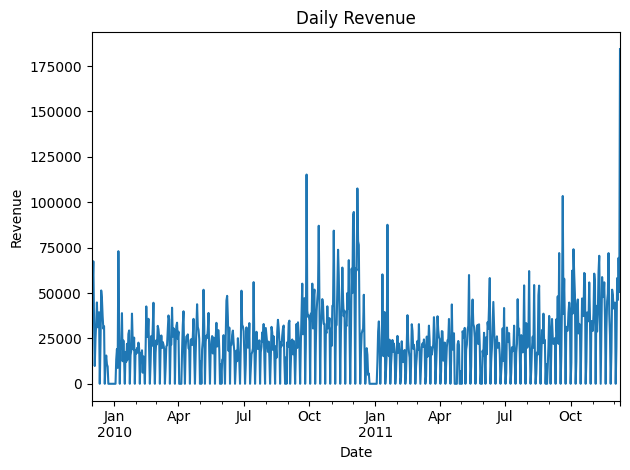

                          Description  TotalPrice
0            REGENCY CAKESTAND 3 TIER   286486.30
1  WHITE HANGING HEART T-LIGHT HOLDER   252072.46
2         PAPER CRAFT , LITTLE BIRDIE   168469.60
3                              Manual   152340.57
4             JUMBO BAG RED RETROSPOT   136980.08
5       ASSORTED COLOUR BIRD ORNAMENT   127074.17
6                             POSTAGE   126563.04
7                       PARTY BUNTING   103880.23
8      MEDIUM CERAMIC TOP STORAGE JAR    81416.73
9     PAPER CHAIN KIT 50'S CHRISTMAS     79594.33


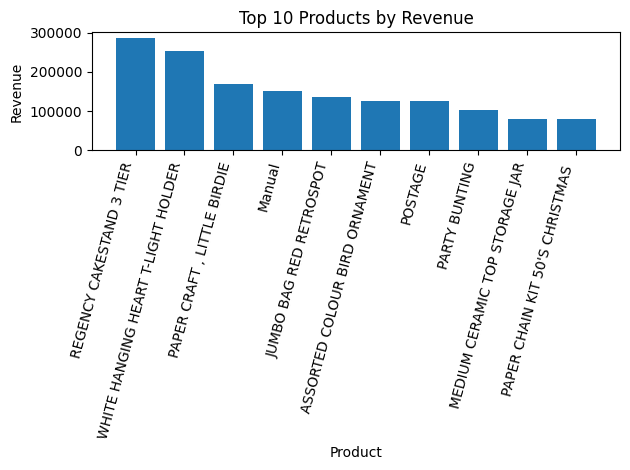

          Country    TotalPrice
0  United Kingdom  1.472315e+07
1            EIRE  6.216311e+05
2     Netherlands  5.542323e+05
3         Germany  4.312625e+05
4          France  3.552575e+05
5       Australia  1.699681e+05
6           Spain  1.091785e+05
7     Switzerland  1.003653e+05
8          Sweden  9.154972e+04
9         Denmark  6.986219e+04


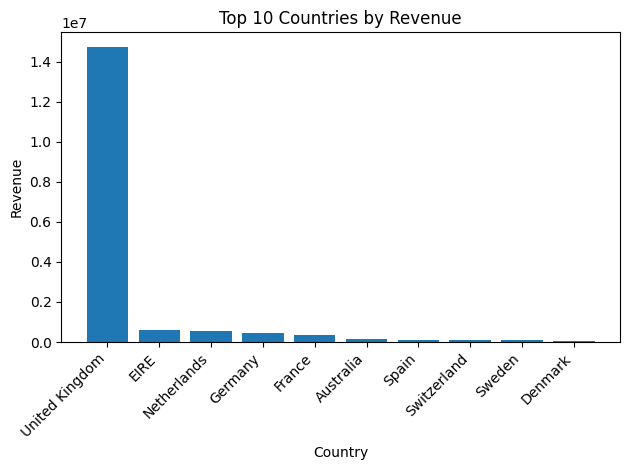

In [ ]:
n_invoices = df['Invoice'].nunique()
n_customers = df['Customer ID'].nunique() if 'Customer ID' in df.columns else df['Invoice'].nunique()
n_products = df['StockCode'].nunique() if 'StockCode' in df.columns else df['Description'].nunique()
gross_revenue = df['TotalPrice'].sum()
print("Unique Invoices :", n_invoices)
print("Unique Customers:", n_customers)
print("Unique Products :", n_products)
print("Gross Revenue   :", round(gross_revenue, 2))
daily = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum().fillna(0)
plt.figure(); daily.plot(title='Daily Revenue'); plt.xlabel('Date'); plt.ylabel('Revenue'); plt.tight_layout(); plt.savefig("/content/outputs/daily_revenue.png"); plt.show()
top_products = (df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index())
print(top_products)
plt.figure(); plt.bar(top_products['Description'], top_products['TotalPrice']); plt.xticks(rotation=75, ha='right'); plt.title('Top 10 Products by Revenue'); plt.xlabel('Product'); plt.ylabel('Revenue'); plt.tight_layout(); plt.savefig("/content/outputs/top_products.png"); plt.show()
if 'Country' in df.columns:
    top_countries = (df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index())
    print(top_countries)
    plt.figure(); plt.bar(top_countries['Country'], top_countries['TotalPrice']); plt.xticks(rotation=45, ha='right'); plt.title('Top 10 Countries by Revenue'); plt.xlabel('Country'); plt.ylabel('Revenue'); plt.tight_layout(); plt.savefig("/content/outputs/top_countries.png"); plt.show()

## RFM

In [ ]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = (df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days, 'Invoice': 'nunique', 'TotalPrice':'sum'})
       .rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','TotalPrice':'Monetary'}))
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Sum'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
rfm.to_csv("/content/outputs/rfm.csv"); rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Sum
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,12
12347.0,2,8,5633.32,5,4,5,14
12348.0,75,5,2019.40,3,4,4,11
12349.0,19,4,4428.69,5,3,5,13
12350.0,310,1,334.40,2,1,2,5


## KMeans Segmentation

Inertias: [12114.97617281138, 7124.406815221331, 5166.45148128436, 3910.3320985787955, 3304.4440083878617, 2737.046003778753]
Silhouette: [np.float64(0.9163500595338631), np.float64(0.5803628394922029), np.float64(0.5905244621382488), np.float64(0.6004114523686472), np.float64(0.54954446742698), np.float64(0.5493743834416007)]


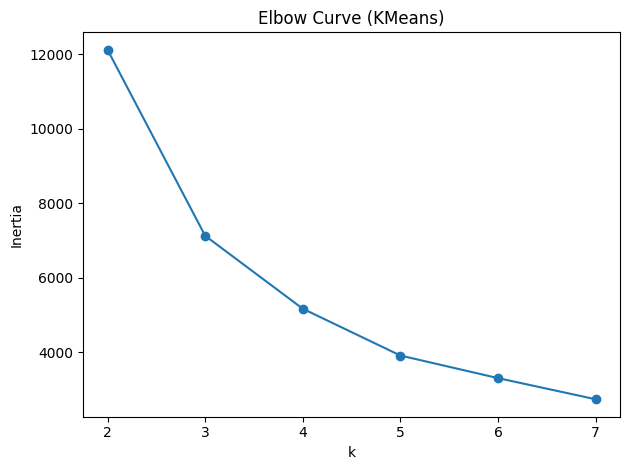

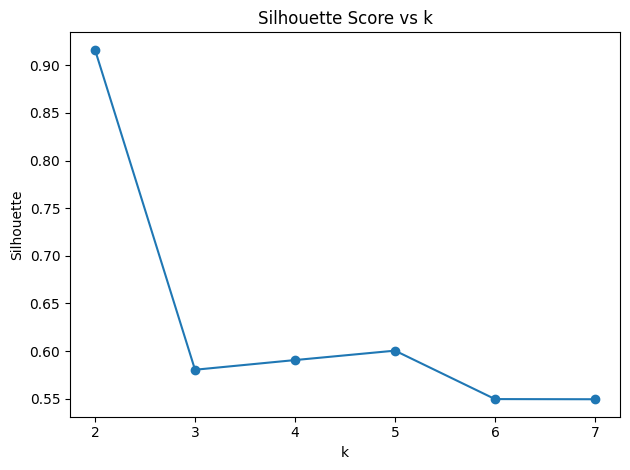

         Recency  Frequency   Monetary  R_Score  F_Score  M_Score  RFM_Sum
Cluster                                                                   
0          67.04       7.28    2986.21     3.82     3.47     3.43    10.71
1         463.03       2.21     765.24     1.41     2.07     2.13     5.61
2           3.50     212.50  436835.79     5.00     5.00     5.00    15.00
3          24.86     100.89   81163.94     4.68     4.92     5.00    14.59


In [ ]:
from sklearn.exceptions import ConvergenceWarning
import warnings; warnings.filterwarnings("ignore", category=ConvergenceWarning)
features = rfm[['Recency','Frequency','Monetary']].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(); X = scaler.fit_transform(features)
inertias, sil_scores = [], []; K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k, n_init=20, random_state=42); labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    from sklearn.metrics import silhouette_score
    sil_scores.append(silhouette_score(X, labels))
print("Inertias:", inertias); print("Silhouette:", sil_scores)
plt.figure(); plt.plot(list(K), inertias, marker='o'); plt.title('Elbow Curve (KMeans)'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.tight_layout(); plt.savefig("/content/outputs/elbow.png"); plt.show()
plt.figure(); plt.plot(list(K), sil_scores, marker='o'); plt.title('Silhouette Score vs k'); plt.xlabel('k'); plt.ylabel('Silhouette'); plt.tight_layout(); plt.savefig("/content/outputs/silhouette.png"); plt.show()
k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=50, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X)
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary','R_Score','F_Score','M_Score','RFM_Sum']].mean().round(2)
print(cluster_profile); cluster_profile.to_csv("/content/outputs/cluster_profile.csv")

## Association Rules (Apriori)

Jumlah Frequent Itemsets: (410, 2)
Jumlah Association Rules: (230, 10)


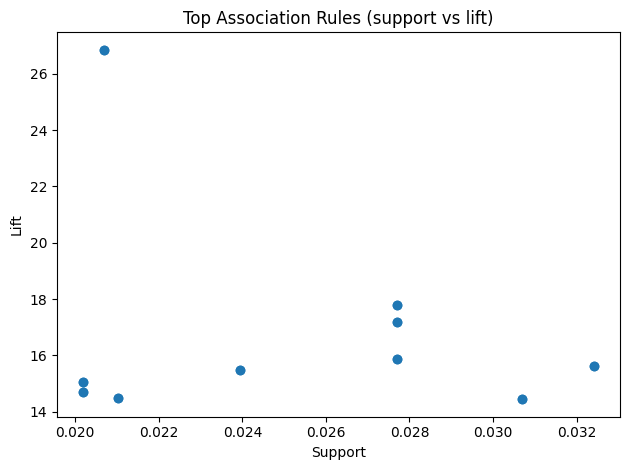

Hasil disimpan di folder /content/outputs


In [ ]:
# === 1. Import Library ===
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import os

# === 2. Siapkan Folder Output ===
os.makedirs("/content/outputs", exist_ok=True)

# === 3. Baca Dataset (hanya 2010-2011) ===
df = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2010-2011")

# === 4. Filter & Bersihkan Data ===
df.dropna(subset=['Invoice', 'Description'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['Country'] == 'United Kingdom']  # Ambil UK saja biar kecil

# Opsional: hapus produk yang jarang terjual
product_counts = df['Description'].value_counts()
common_products = product_counts[product_counts > 50].index  # produk muncul lebih dari 50x
df = df[df['Description'].isin(common_products)]

# === 5. Buat Basket (Invoice x Produk) ===
basket = (df.groupby(['Invoice', 'Description'])['Quantity']
            .sum()
            .unstack()
            .fillna(0))

# === 6. Ubah ke Boolean (True/False) ===
basket = (basket > 0)

# === 7. Algoritma Apriori ===
freq = apriori(basket, min_support=0.02, use_colnames=True)  # min_support diperbesar biar cepat
rules = association_rules(freq, metric='lift', min_threshold=1.0).sort_values('lift', ascending=False)

print("Jumlah Frequent Itemsets:", freq.shape)
print("Jumlah Association Rules:", rules.shape)

# === 8. Simpan Hasil ke CSV ===
freq.to_csv("/content/outputs/frequent_itemsets.csv", index=False)
rules.to_csv("/content/outputs/association_rules.csv", index=False)

# === 9. Visualisasi Top Rules ===
top_rules = rules.head(20)
plt.figure()
plt.scatter(top_rules['support'], top_rules['lift'])
plt.title('Top Association Rules (support vs lift)')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.tight_layout()
plt.savefig("/content/outputs/rules_scatter.png")
plt.show()

print("Hasil disimpan di folder /content/outputs")


Penjelasan singkat untuk laporan:

Tujuan: Mencari pola pembelian produk yang sering muncul bersamaan (Market Basket Analysis)

Algoritma: Apriori karena cocok untuk menemukan frequent itemsets dan membuat association rules dari data transaksi.

Alasan: Apriori sederhana, interpretasinya mudah, dan sering digunakan untuk analisis keranjang belanja di retail.

## Cohort Retention

CohortIndex  0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0   \
CohortMonth                                                                 
2010-12-01    1.0  0.359  0.324  0.376  0.364  0.401  0.361  0.341  0.357   
2011-01-01    1.0  0.212  0.263  0.238  0.334  0.275  0.252  0.244  0.303   
2011-02-01    1.0  0.192  0.198  0.288  0.288  0.252  0.258  0.279  0.270   
2011-03-01    1.0  0.153  0.259  0.199  0.225  0.163  0.264  0.230  0.283   
2011-04-01    1.0  0.208  0.204  0.215  0.201  0.223  0.223  0.266  0.073   
2011-05-01    1.0  0.184  0.176  0.172  0.207  0.223  0.270  0.086  0.000   
2011-06-01    1.0  0.172  0.149  0.242  0.237  0.321  0.098  0.000  0.000   
2011-07-01    1.0  0.181  0.193  0.228  0.275  0.111  0.000  0.000  0.000   
2011-08-01    1.0  0.227  0.234  0.241  0.121  0.000  0.000  0.000  0.000   
2011-09-01    1.0  0.227  0.300  0.116  0.000  0.000  0.000  0.000  0.000   

CohortIndex   9.0    10.0   11.0   12.0  
CohortMonth                      

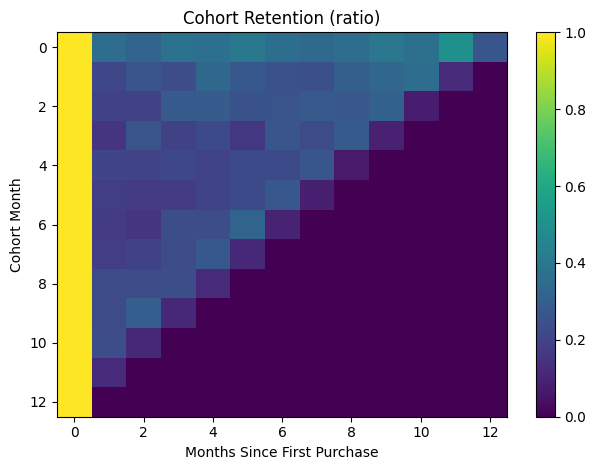

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].values.astype('datetime64[M]')
first_purchase = df.groupby('Customer ID')['InvoiceMonth'].min().rename('CohortMonth')
df2 = df.join(first_purchase, on='Customer ID')
def get_month_diff(d1, d2): return (d1.year - d2.year) * 12 + (d1.month - d2.month)
df2['CohortIndex'] = df2.apply(lambda r: get_month_diff(r['InvoiceMonth'], r['CohortMonth']), axis=1)
cohort_pivot = (df2.groupby(['CohortMonth','CohortIndex'])['Customer ID'].nunique().unstack().fillna(0))
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)
print(retention.head(10))
retention.to_csv("/content/outputs/cohort_retention.csv")
plt.figure(); plt.imshow(retention, aspect='auto', interpolation='nearest'); plt.title('Cohort Retention (ratio)'); plt.ylabel('Cohort Month'); plt.xlabel('Months Since First Purchase'); plt.colorbar(); plt.tight_layout(); plt.savefig("/content/outputs/cohort_heatmap.png"); plt.show()

## Ekspor

In [ ]:
import shutil

# Buat file zip dari folder outputs
shutil.make_archive('/content/outputs', 'zip', '/content/outputs')


'/content/outputs.zip'

Semua output tersimpan di `/content/outputs`.